# Convolutional Neural Network Smile Detection
    
### Deep CNN: 2 hidden layers 64, 64; fully connected 64 neurons. 

##  Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
import matplotlib.pyplot as plt
from time import time
import os
import tensorflow as tf
from time import time

from pylab import rcParams
rcParams['figure.figsize'] = 12,10

##  Fetch dataset

In [2]:
#All images provided to the classifier should have fixed and equal sizes
dim = (64, 64)

def fetch_category_images(path_to_subject, subject_number):
    
    X = np.array([])
    index = 0
    for subject_img in os.listdir(path_to_subject): #for each image in this subject's folder
        img_path = os.path.join(path_to_subject, subject_img)
        if img_path.endswith(".pgm") or img_path.endswith(".png") or img_path.endswith(".jpg") or img_path.endswith(".jpeg"):
            #Read image, convert it to grayscale and resize every image to a fixed size  
            img = cv2.resize(cv2.imread(img_path, 0), dim, interpolation = cv2.INTER_AREA) 
            
            #img_data = img.ravel()  #Flatten each image, so that each sample is a 1D vector
            img_data = img[np.newaxis, :, :]
            X = img_data if not X.shape[0] else np.vstack((X, img_data))
            index += 1

    y = np.empty(index, dtype = int) #index = total no. of samples
    y.fill(subject_number)  #add labels
    return X, y

def fetch_data(dataset_path):

    # Get a the list of folder names in the path to dataset
    labels_list = [d for d in os.listdir(dataset_path) if "." not in str(d)]
    X = np.empty([0, dim[0], dim[1]])
    y = np.empty([0])

    for i in range(0, len(labels_list)):  #for each person
        subject = str(labels_list[i])  #person i in list of ppl
        path_to_subject = os.path.join(dataset_path, subject) #full path to this person's directory
        
        #Read all images in this folder (all images of this person)
        X_, y_ = fetch_category_images(path_to_subject, i)
        X = np.concatenate((X, X_), axis=0)
        y = np.append(y, y_)
        print("Class {}: '{}', {} images loaded".format(i, labels_list[i], X_.shape[0]))

    return X, y, labels_list

# Load training data 
dataset_path = "Smile_dataset/"
X, y, labels_list  = fetch_data(dataset_path)

Class 0: 'negatives', 9475 images loaded
Class 1: 'positives', 3690 images loaded


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

n_classes = len(np.unique(y))
print("Dataset consists of {} samples and  {} classes".format(X.shape[0], n_classes))
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.reshape(y, (-1, 1))).toarray()

print("Data: {} and one hot encoded labels: {}".format(X.shape, labels.shape))                                                                                           
print(" ")
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20, random_state=42)
print("Training data {}, test data {}".format(X_train.shape,X_test.shape))

Dataset consists of 13165 samples and  2 classes
Data: (13165, 64, 64) and one hot encoded labels: (13165, 2)
 
Training data (10532, 64, 64), test data (2633, 64, 64)


##  Train CNN

In [4]:
width = 64
height = 64

n_features = height*width
channels = 1

feature_map1 = 64
ksize_conv1 = 2
stride_conv1 = 1

feature_map2 = 64
ksize_conv2 = ksize_conv1
stride_conv2 = stride_conv1

pool_layer_maps2 = feature_map2

n_fully_conn1 = 64
  
X = tf.placeholder(tf.float32, shape=[None, height, width])
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
y = tf.placeholder(tf.int32, shape=[None, n_classes])

xavier_init = tf.contrib.layers.xavier_initializer()
relu_act = tf.nn.relu

# ------------------ Convolutional and pooling layers ----------------------------

def convolutional_layer(X, filter_, ksize, kernel_init, strides, padding):
    convolutional_layer = tf.layers.conv2d(X, filters = filter_, kernel_initializer = kernel_init,
                                           kernel_size = ksize, strides = strides,
                                          padding = padding, activation = relu_act)
    return convolutional_layer

def pool_layer(convlayer, ksize, strides, padding, pool_maps):
    pool = tf.nn.max_pool(convlayer, ksize, strides, padding)
    dim1, dim2 = int(pool.get_shape()[1]), int(pool.get_shape()[2])
    pool_flat = tf.reshape(pool, shape = [-1, pool_maps * dim1 * dim2])
    return pool_flat

conv_layer1 = convolutional_layer(X_reshaped, feature_map1, ksize_conv1, xavier_init, stride_conv1, padding = "SAME")

conv_layer2 = convolutional_layer(conv_layer1, feature_map2, ksize_conv2, xavier_init, stride_conv2, padding = "SAME")

pool_layer2_flat = pool_layer(conv_layer2, [1,2,2,1], [1,2,2,1], "VALID", pool_layer_maps2)

# ----------------- Fully connected layer -------------------

def dense_layer(input_layer, n_neurons, kernel_init, activation):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init)
    return fully_conn
        
dense_layer1 = dense_layer(pool_layer2_flat, n_fully_conn1, xavier_init, relu_act)

#--------------------------------------------------------------

logits = tf.layers.dense(dense_layer1, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train.shape[0]
n_iter = n_train//batch_size
path = "./cnn_imbalance1"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20 

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    
print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test})

EPOCH 0
Train accuracy = 0.875, train loss = 0.343394935131073
Validation loss: 0.3513079881668091, minimum loss: 0.3513079881668091, validation accuracy: 0.8742879033088684
 
EPOCH 1
Train accuracy = 0.890625, train loss = 0.24759231507778168
Validation loss: 0.2835156321525574, minimum loss: 0.2835156321525574, validation accuracy: 0.8879604935646057
 
EPOCH 2
Train accuracy = 0.9375, train loss = 0.15811553597450256
Validation loss: 0.26932233572006226, minimum loss: 0.26932233572006226, validation accuracy: 0.8982149362564087
 
EPOCH 3
Train accuracy = 0.96875, train loss = 0.09404662251472473
Validation loss: 0.2892078459262848, minimum loss: 0.26932233572006226, validation accuracy: 0.8860615491867065
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.09675861895084381
Validation loss: 0.3423548638820648, minimum loss: 0.26932233572006226, validation accuracy: 0.873148500919342
 
EPOCH 5
Train accuracy = 0.921875, train loss = 0.18473386764526367
Validation loss: 0.3127437531948

##  Evaluate the model

In [5]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

             precision    recall  f1-score   support

  negatives       0.91      0.96      0.93      1937
  positives       0.86      0.73      0.79       696

avg / total       0.90      0.90      0.90      2633



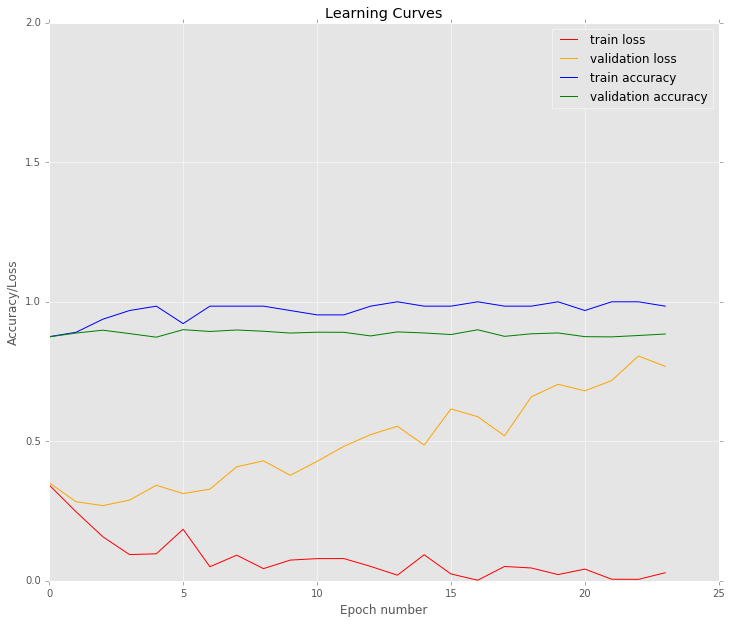

In [12]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()